In [27]:
import os
import yaml
import json
import logging
import numpy as np
import pandas as pd
import xarray as xr
import seqdata as sd
import seqpro as sp

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

In [10]:
from eugene.prep_dataset.utils import merge_parameters, infer_covariate_types

In [11]:
# 
path_params = "/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/SC.delta/SC.delta.sample.yaml"

In [16]:
from eugene.prep_dataset.tabular import default_params

In [17]:
with open(path_params, "r") as f:
    params = yaml.safe_load(f)
params

{'base': {'name': 'SC.delta.sample', 'threads': 4, 'random_state': 1234},
 'seqdata': {'fasta': '/cellar/users/aklie/data/ref/genomes/hg38/hg38.fa',
  'seq_var': 'seq',
  'bws': ['/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/SC.delta/SC.delta_unstranded.bw'],
  'bw_names': ['SC.delta'],
  'cov_var': 'cov',
  'peaks': '/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/SC.delta/SC.delta.sample.narrowPeak',
  'batch_size': 1000,
  'fixed_length': 2114,
  'target_length': 1000,
  'alphabet': 'DNA',
  'upper_case': False,
  'add_rev_comp': False,
  'max_jitter': 512},
 'negatives': {'gc_bin_width': 0.02,
  'max_n_perc': 0.1,
  'signal': '/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/SC.delta/SC.delta_unstranded.bw',
  'signal_beta': 0.5,
  'in_window': 2114,
  'out_window': 1000,
  'random_state': 1234},
 'splits': '/cellar/users/aklie/projects/ML4GLand/tutorials/data/splits/ENCODE_cross-val.json',
 'kmer_analysis': {'k': [5],
  'n

In [18]:
params = merge_parameters(path_params, default_params)
params

{'base': {'name': 'SC.delta.sample', 'threads': 4, 'random_state': 1234},
 'seqdata': {'fasta': '/cellar/users/aklie/data/ref/genomes/hg38/hg38.fa',
  'seq_var': 'seq',
  'bws': ['/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/SC.delta/SC.delta_unstranded.bw'],
  'bw_names': ['SC.delta'],
  'cov_var': 'cov',
  'peaks': '/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/SC.delta/SC.delta.sample.narrowPeak',
  'batch_size': 1000,
  'fixed_length': 2114,
  'target_length': 1000,
  'alphabet': 'DNA',
  'upper_case': False,
  'add_rev_comp': False,
  'max_jitter': 512,
  'overwrite': False},
 'negatives': {'gc_bin_width': 0.02,
  'max_n_perc': 0.1,
  'signal': '/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/SC.delta/SC.delta_unstranded.bw',
  'signal_beta': 0.5,
  'in_window': 2114,
  'out_window': 1000,
  'random_state': 1234},
 'splits': '/cellar/users/aklie/projects/ML4GLand/tutorials/data/splits/ENCODE_cross-val.json',
 'kmer_anal

# Load SeqData object

In [20]:
path_out = "/cellar/users/aklie/projects/ML4GLand/EUGENe/examples/prep_dataset/SC.delta"
name = params["base"]["name"]

In [24]:
out = os.path.join(path_out, f"{name}.full.seqdata")

In [25]:
sdata = sd.open_zarr(out)

# GC content

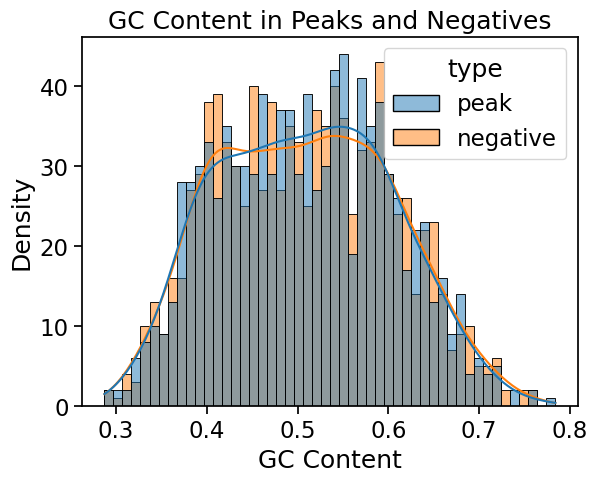

GC-bin KS test stat:0.018, p-value 0.997


In [33]:
seq_df = sdata[["chrom", "chromStart", "chromEnd", "type", "gc_percent"]].to_dataframe()
with sns.plotting_context("notebook", font_scale=1.5):
    sns.histplot(seq_df, x="gc_percent", hue="type", bins=50, kde=True)
    plt.xlabel("GC Content")
    plt.ylabel("Density")
    plt.title("GC Content in Peaks and Negatives")
    plt.show()
loci_gc = seq_df.query("type == 'peak'")["gc_percent"].values
matched_gc = seq_df.query("type == 'negative'")["gc_percent"].values
stats = ks_2samp(loci_gc, matched_gc)
print("GC-bin KS test stat:{:3.3}, p-value {:3.3}".format(stats.statistic, stats.pvalue))

# Percent non-alphabet characters

In [40]:
n_max_percent = 0.2
n_bins = 5

In [44]:
seq_df = sdata[["chrom", "chromStart", "chromEnd", "type", "non_alphabet_cnt", "length"]].to_dataframe()
seq_df["non_alphabet_percent"] = seq_df["non_alphabet_cnt"] / seq_df["length"]

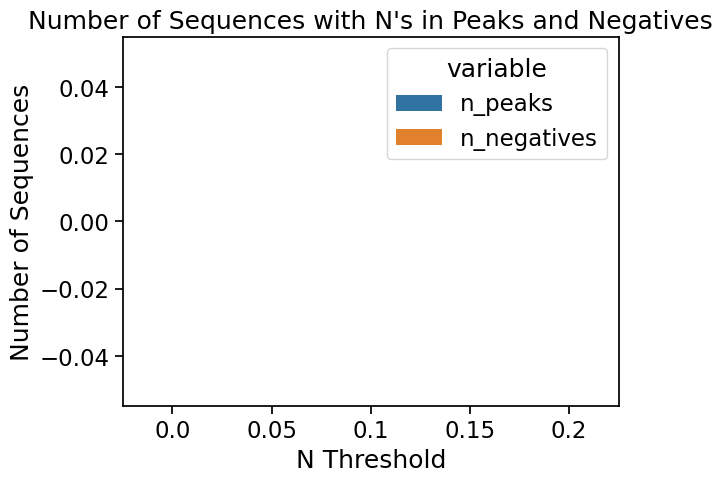

In [49]:
n_thresholds = np.linspace(0, n_max_percent, n_bins)
peak_n_over_threshold = np.array([np.sum(seq_df.query("type == 'peak'")["non_alphabet_percent"] > n) for n in n_thresholds])
neg_n_over_threshold = np.array([np.sum(seq_df.query("type == 'negative'")["non_alphabet_percent"] > n) for n in n_thresholds])

# create a dataframe for plotting
n_df = pd.DataFrame({
    "n_threshold": n_thresholds,
    "n_peaks": peak_n_over_threshold,
    "n_negatives": neg_n_over_threshold
})

# round n_threshold to 2 decimal places
n_df["n_threshold"] = n_df["n_threshold"].round(2)

with sns.plotting_context("notebook", font_scale=1.5):
    sns.barplot(data=n_df.melt(id_vars="n_threshold"), x="n_threshold", y="value", hue="variable")
    plt.xlabel("N Threshold")
    plt.ylabel("Number of Sequences")
    plt.title("Number of Sequences with N's in Peaks and Negatives")
    plt.show()

# Total count distributions

/cellar/users/aklie/opt/miniconda3/envs/eugene_tools/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3251411/1177585221.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


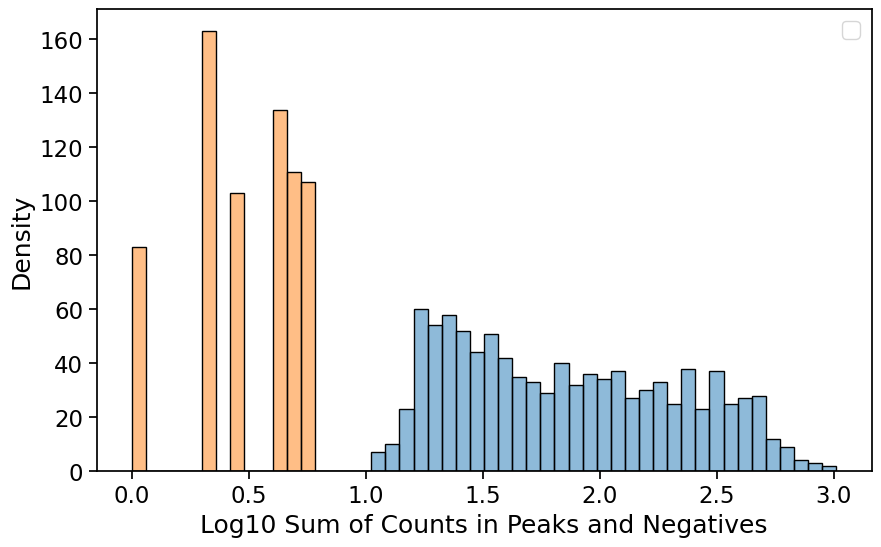

In [54]:
# Plot the distribution of peak and negative counts
seq_df = sdata[["chrom", "chromStart", "chromEnd", "type", "total_counts"]].to_dataframe()
seq_df["log10_total_counts"] = np.log10(seq_df["total_counts"])
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 6))
    sns.histplot(seq_df, x="log10_total_counts", hue="type", bins=50)
    plt.xlabel("Log10(Sum of Counts) in Peaks and Negatives")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot the tracks

In [55]:
def plot_tracks(tracks, interval, height=1.5, colors=None):
  _, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  if not isinstance(axes, np.ndarray):
    axes = [axes]
  for ax, (title, y) in zip(axes, tracks.items()):
    if colors is not None:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y, color=colors[title])
    else:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(f"{interval['chrom']}:{interval['start']}-{interval['end']}")
  plt.tight_layout()

In [58]:
sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe()

,name,chrom,chromStart,chromEnd
_sequence,,,,
peak_0,.,c,1832106,1835244
peak_1,.,c,1942591,1945729
peak_2,.,c,2545461,2548599
peak_3,.,c,3939040,3942178
peak_4,.,c,9003727,9006865
...,...,...,...,...
negative_995,n,c,18327868,18331006
negative_996,n,c,22644656,22647794
negative_997,n,c,23082254,23085392


In [60]:
ser = sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_id]
ser

name                .
chrom               c
chromStart    1832106
chromEnd      1835244
Name: peak_0, dtype: object

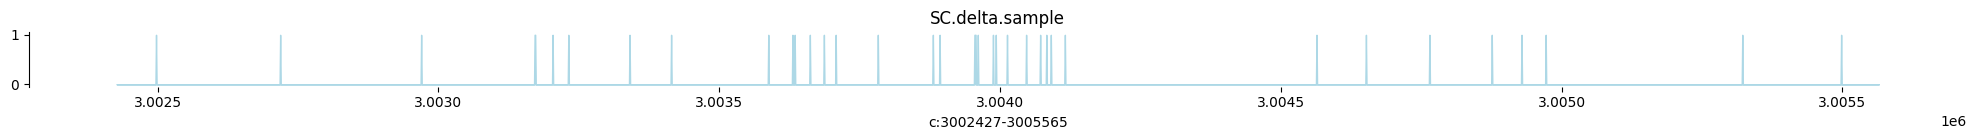

In [70]:
# Get data
seq_id = "peak_999"
ser = sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_id]
sdata_vals = sdata["cov"].sel(_sequence=seq_id).values.squeeze()
chrom = ser["chrom"]
chromStart = ser["chromStart"]
chromEnd = ser["chromEnd"]
interval = dict(chrom=chrom, start=chromStart, end=chromEnd)
tracks = {
    name: sdata_vals,
}
colors = {
    name: "lightblue",
}

# Plot tracks
plot_tracks(
    tracks=tracks,
    interval=interval,
    colors=colors
)

# Splits

Text(0.5, 1.0, 'Training and Validation Folds')

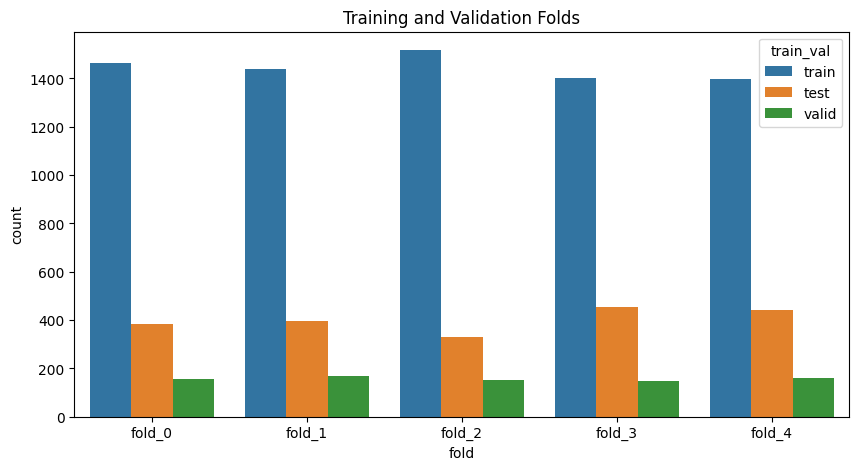

In [50]:
# Make a barplot that shows the number of sequences in each fold, split into training and validation within each bar
fold_df = sdata[["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"]].to_pandas().melt().groupby("variable").value.value_counts().reset_index()
fold_df.columns = ["fold", "train_val", "count"]
fold_df["train_val"] = fold_df["train_val"].astype(str)
fold_df["fold"] = fold_df["fold"].astype(str)

plt.figure(figsize=(10, 5))
sns.barplot(x="fold", y="count", hue="train_val", data=fold_df)
plt.title("Training and Validation Folds")